Este é um exercício para me familiarizar com a plataforma Kaggle e suas competições.

Tentarei resolver esse problema e melhorar a pontuação baseando-se em metodos e ideias que vi em notebooks compartilhados por cientistas de dados da comunidade mais experientes.

**Boa parte dos insights mais relevantes para a resolução do problema não partiram de mim. Créditos no final do projeto** 
- https://www.kaggle.com/startupsci/titanic-data-science-solutions

- https://www.kaggle.com/tuckerarrants/titanic-ml-top-10


<font size="5">**Importando dados e bibliotecas necessárias**</font>

In [25]:
# análise e transformação dos dados
import pandas as pd
import numpy as np
import random as rnd

# visualização
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [26]:
# para melhorar a visualização de tabelas

from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [27]:
# importando os datasets

import os

train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
all_data = train_df.append(test_df, sort=True);

In [28]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


<font size="5">**Análise exploratória**</font>

In [29]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [30]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Davies, Master. John Morgan Jr",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [31]:
# Número de "NaN"s em cada feature
print(all_data.shape)
all_data.isnull().sum().drop('Survived')

(1309, 12)


Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Ticket            0
dtype: int64

<font size="3">**Observações**</font>
:
- Cinco features são nominais, das quais apenas "Sex" e "Embarked" possuem poucos valores únicos e podem ser facilmente convertidas em variáveis numéricas ordinais/discretas.

- Proporção de "Missing values" encontrados: "Cabin" 77%  >>> "Age" 20% >> "Embarked" apenas 2 > "Fare" apenas 1.

- A chance de sobrvivência média é de 38% e pode ser usado como parâmetro de comparação para o impacto de determinadas features.

<font size="3">**Especulações**</font>
:
- PassangerId, Cabin, Ticket e Name provavelmente não contribuem para a sobrevivência, descartá-los logo no início é conveniente pois reduz o volume de dados, acelera o processamento do código e simplifica a análise, mas vale ressaltar que o nome também possui informações sobre o título do passageiro, extraír isso em uma nova feature pode beneficiar a acuracia do modelo.

- É importante saber quais features se correlacionam com a sobrevivência e entre sí logo no início do projeto, pois isso guia a tomada de decisão sobre quais delas manter e transformar; alguns dados como o valor da tarifa (Fare) e classe (Pclass) podem acabar dizendo a mesma coisa ficando redundantes

- Se queremos fazer correlações logo de início, é importante converter features potencialmente relevantes como  "Sex" e "Embarked" para variáveis ordinais/discretas antes.

- Por fim, se a análise apontar que features incompletas como "Age" e "Embarked" impactam na sobrevivência, devem ser completadas ao invés de descartadas.

In [32]:
# Extraindo os títulos de "Name"
all_data['Title'] = all_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(all_data['Title'], all_data['Sex']).T

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [33]:
# Descartando dados irrelevantes

Id_test = test_df['PassengerId'] # necessário para submissão do projeto.

all_data = all_data.drop(['PassengerId','Ticket','Cabin','Name'], axis=1)

train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]

<font size="5">**Checando correlações com a sobrevivência**</font>

In [34]:
def pivota_feature_com_sobrev(feature_analisada):
    
    #Essa função cria um pequeno DataFrame com a taxa de sobrevivência 
    #e o número de indivíduos de cada elemento de uma feature.
    
    df_pivot = pd.concat([train_df[feature_analisada].rename('# ind').value_counts(), 
                          train_df[[feature_analisada, "Survived"]].groupby(feature_analisada, as_index=True).mean()], 
                         axis=1, sort=True)
    
    df_pivot.index.name = feature_analisada
    
    return df_pivot

In [35]:
display(pivota_feature_com_sobrev('Sex'), 
        pivota_feature_com_sobrev('Embarked'), 
        pivota_feature_com_sobrev('Pclass'))

,# ind,Survived
Sex,,
female,314,0.742038
male,577,0.188908


,# ind,Survived
Embarked,,
C,168,0.553571
Q,77,0.389610
S,644,0.336957


,# ind,Survived
Pclass,,
1,216,0.629630
2,184,0.472826
3,491,0.242363


Todas estas três features aparentam impactar nas chances de sobrevivência; devem ser preenchidas e convertidas para variáveis numéricas.

In [36]:
all_data['Sex'].replace(['female','male'], [0, 1],inplace=True)

all_data['Embarked'].fillna('S', inplace=True)
all_data['Embarked'].replace(['S', 'Q', 'C'], [0, 1, 2],inplace=True)

In [37]:
display(pivota_feature_com_sobrev('Title'), 
        pivota_feature_com_sobrev('Parch'), 
        pivota_feature_com_sobrev('SibSp'))

,# ind,Survived
Title,,
Capt,1,0.000000
Col,2,0.500000
Countess,1,1.000000
Don,1,0.000000
Dr,7,0.428571
Jonkheer,1,0.000000
Lady,1,1.000000
Major,2,0.500000
Master,40,0.575000


,# ind,Survived
Parch,,
0,678,0.343658
1,118,0.550847
2,80,0.500000
3,5,0.600000
4,4,0.000000
5,5,0.200000
6,1,0.000000


,# ind,Survived
SibSp,,
0,608,0.345395
1,209,0.535885
2,28,0.464286
3,16,0.250000
4,18,0.166667
5,5,0.000000
8,7,0.000000


Nota-se que grande parte dos indivídios que tiveram companhia para a viagem ou Títulos raros tiveram mais de 50% de chance de sobreviver. Entretanto muitos desses elementos não possuem um número de indivíduos alto o suficiente para serem representativos do todo, transformar esta feature em uma variável ordinal pode incorrer em problemas de amostragem para determiandos valores, fazendo mais sentido criar as seguintes variáveis binárias: 

- "Family": 0 para indivíduos sozinhos e 1 para acompanhados.
- "Credentials": 1 para indivíduos cujo título aparenta ter melhorado suas chances de sobreviver (comparados com a chance base de homens e mulheres, por exemplo, Miss é um título exclusivamente feminino que está acima da taxa global de 38% de sobrevivência, mas por estar abaixo da taxa média de mulheres de 74%, lhe será atribuido o valor 0).



In [38]:
# Outro motivo para criar a feature "Family" é a alta correlação entre "Parch" e "SibSp", indicando que
# provavelmente agregam informações muito similares e redundantes

all_data.corr()['Parch']['SibSp']

0.3735871906264894

In [39]:
# Criando a feature "Credentials"
all_data["Credentials"] = all_data['Title'].replace(['Mrs', 'Dona', 'Capt', 'Ms', 'Mme', 'Lady', 'Jonkheer', 'Sir', 'Don', 'Countess',
       'Major', 'Mlle', 'Col', 'Dr', 'Master'], 1).replace(['Rev', 'Miss', 'Mr'], 0)

# Criando a feature "Family"
all_data['Family'] =  all_data["Parch"] + all_data["SibSp"]
all_data.loc[all_data['Family'] > 0, 'Family'] = 1

# Descartando
all_data.drop(['SibSp', 'Parch', 'Title'], axis=1, inplace=True)

<font size="5">**Matriz de correlações**</font>

In [40]:
# Split
train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]

train_df.corr().style.background_gradient(cmap='Blues').set_precision(2)

,Age,Embarked,Fare,Pclass,Sex,Survived,Credentials,Family
Age,1,0.03,0.096,-0.37,0.093,-0.077,0.0032,-0.2
Embarked,0.03,1,0.22,-0.16,-0.11,0.17,0.041,0.064
Fare,0.096,0.22,1,-0.55,-0.18,0.26,0.11,0.27
Pclass,-0.37,-0.16,-0.55,1,0.13,-0.34,-0.17,-0.14
Sex,0.093,-0.11,-0.18,0.13,1,-0.54,-0.38,-0.3
Survived,-0.077,0.17,0.26,-0.34,-0.54,1,0.36,0.2
Credentials,0.0032,0.041,0.11,-0.17,-0.38,0.36,1,0.43
Family,-0.2,0.064,0.27,-0.14,-0.3,0.2,0.43,1


A correlação entre a idade e a sobrevivência é baixa (-0,07), entretando, se analizamos as curvas de kde encontramos faixas estárias mais propensas a sobreviverem. Isso sugere que a feature é relevante para o modelo e deve ser completada.

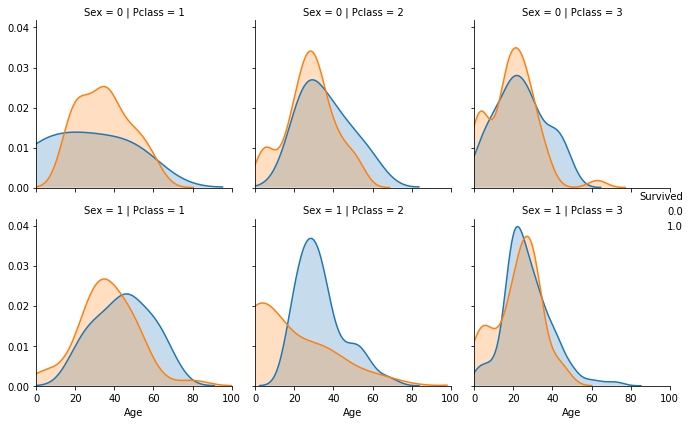

In [41]:
kde_age= sns.FacetGrid(train_df, col='Pclass', row='Sex', hue='Survived')
kde_age.add_legend().set(xlim=(0, 100))
kde_age = kde_age.map(sns.kdeplot, 'Age', shade=True)

Uma possibilidade para completar as informações de idade é preenche-las com a mediana das idades, mas este valor pode variar em função de diferentes grupos de pessoas. Vale checar as features "Family" e "Pclass", que são as que mais se correlacionam com "Age":

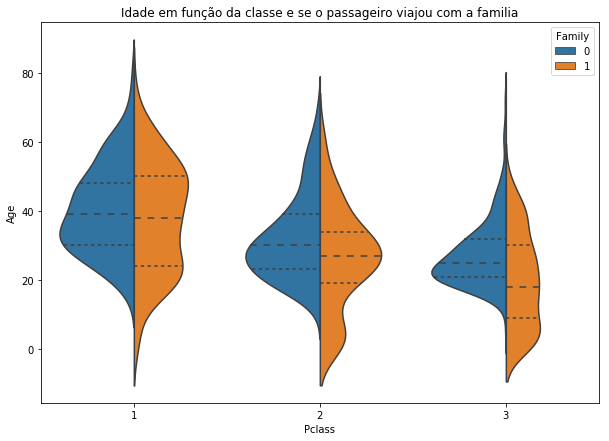

In [42]:
plt.figure(figsize = (10, 7))
plt.title('Idade em função da classe e se o passageiro viajou com a familia')
sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Family', data = all_data, split = True, inner="quartile")
plt.show()

<font size="5">**Preenchendo missing values**</font>
.

Assim como esperado, diferentes grupos possuem diferentes distribuições de idades, e uma vez que possuimos estas informações, a feature Age será preenchida de forma condicionada a estas informações:

In [43]:
matriz_de_medianas = np.zeros((2,3))

for classe in range(1, 4):
    for familia in range(0, 2):
        matriz_de_medianas[familia, classe - 1] = all_data.loc[(all_data['Pclass'] == classe) & (all_data['Family'] == familia)]['Age'].median()
        
        all_data.loc[(np.isnan(all_data['Age'])) 
                     & (all_data['Family'] == familia) 
                     & (all_data['Pclass'] == classe), 'Age'] = matriz_de_medianas[familia, classe - 1]

medianas = pd.DataFrame(matriz_de_medianas, columns=[1, 2, 3]); medianas.index.name = 'Family'; medianas.columns.name = 'Pclass'
medianas

Pclass,1,2,3
Family,,,
0,39.0,30.0,25.0
1,38.0,27.0,18.0


O mesmo é realizado para preencher o único valor nulo da feature "Fare"

In [44]:
all_data.loc[np.isnan(all_data['Fare'])]

,Age,Embarked,Fare,Pclass,Sex,Survived,Credentials,Family
152,60.5,0,NaN,3,1,NaN,0,0


In [45]:
all_data.loc[np.isnan(all_data['Fare'])] = all_data.loc[(all_data['Pclass'] == 3) & (all_data['Sex'] == 1) & (all_data['Family'] == 0)]['Fare'].median()

In [51]:
# Nossos dados estão finalmente organizados, limpos e transformados:
all_data.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Credentials,Family
0,22.0,0.0,7.2500,3.0,1.0,0.0,0.0,1.0
1,38.0,2.0,71.2833,1.0,0.0,1.0,1.0,1.0
2,26.0,0.0,7.9250,3.0,0.0,1.0,0.0,0.0
3,35.0,0.0,53.1000,1.0,0.0,1.0,1.0,1.0
4,35.0,0.0,8.0500,3.0,1.0,0.0,0.0,0.0


<font size="5">**Modelagem e predição**</font>

In [46]:
train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]

X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("Survived", axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [47]:
# Logistic Regression

logreg = LogisticRegression(solver= 'liblinear')
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(acc_log)

81.82


In [48]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.2

In [52]:
submission = pd.DataFrame()
submission['PassengerId'] = Id_test
#get predictions
submission['Survived'] = Y_pred
submission.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PassengerId,892.0,893.0,894.0,895.0,896.0,897.0,898.0,899.0,900.0,901.0,902.0,903.0,904.0,905.0,906.0
Survived,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [50]:
submission.to_csv('random_forest_submission.csv', index=False)